# Capstone Project: Integrated Field Development Study (Phoenix Field)

**Author:** Ade Anggi Naluriawan Santoso
**Date:** 2025-12-31
**Reference:** *Reservoir Engineering Handbook* (Tarek Ahmed)

---

## 1. Executive Summary
The Phoenix field is a saturated oil reservoir located at 8,500 ft. Based on this integrated study, we estimate:
* **Fluid Type:** Black Oil (35° API).
* **OOIP:** ~27 MMSTB.
* **Single Well Potential:** ~1,200 STB/D initial rate.
* **Primary Recovery:** ~14% (Solution Gas Drive).
* **Waterflood Potential:** Increases recovery to ~38%.

---

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit, fsolve
from scipy.misc import derivative

# Global Plotting Style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11

print("--- Phoenix Field Environment Initialized ---")

--- Phoenix Field Environment Initialized ---


## 2. Fluid Characterization (PVT Modeling)

**Task:** We have basic field data but no full lab report. We must generate a synthetic PVT table ($B_o, R_s, \mu_o$) using **Vasquez-Beggs** and **Beggs-Robinson** correlations (Chapters 2 & 3).

**Input Data:**
* Reservoir Pressure ($P_i$): 3500 psi
* Reservoir Temperature ($T$): 210°F
* Oil Gravity: 35° API
* Gas Specific Gravity: 0.75
* Gas-Oil Ratio ($R_{si}$): 700 scf/STB

Calculated Bubble Point (Pb): 3301 psi


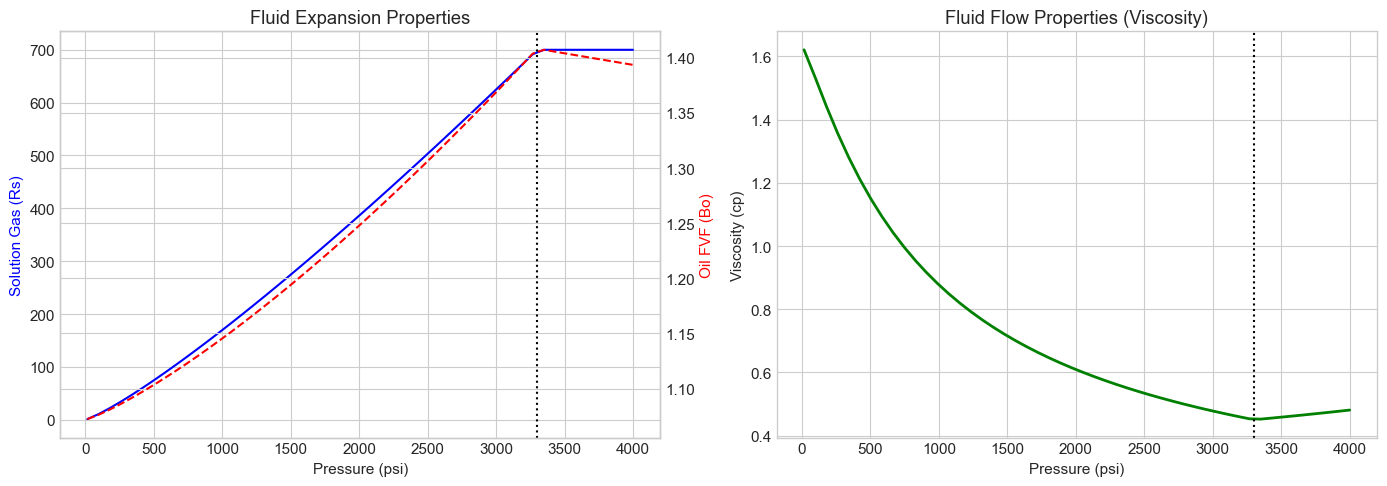

In [2]:
# --- STEP 1: DEFINE CORRELATIONS ---

def calc_pvt_correlations(P_array, T, API, sg_gas, Rsi):
    """
    Generates Black Oil properties for a pressure array.
    Uses Vasquez-Beggs (Rs, Bo) and Beggs-Robinson (Viscosity).
    """
    results = []
    
    # Constants for Vasquez-Beggs (API > 30)
    C1, C2, C3 = 0.0178, 1.1870, 23.931
    C_bo1, C_bo2, C_bo3 = 4.670e-4, 1.100e-5, 1.337e-9
    
    # Calculate Bubble Point (Inverse of Rs correlation)
    # Pb = [ Rs / (C1 * sg * exp(C3 * API / (T+460))) ] ^ (1/C2)
    term_exp = np.exp((C3 * API) / (T + 460))
    Pb = (Rsi / (C1 * sg_gas * term_exp))**(1 / C2)
    
    for P in P_array:
        # 1. Solution Gas Ratio (Rs)
        if P >= Pb:
            Rs = Rsi
        else:
            # Rs = C1 * sg * P^C2 * exp(...)
            Rs = C1 * sg_gas * (P**C2) * term_exp
            
        # 2. Oil FVF (Bo)
        # Bo = 1 + C_bo1*Rs + C_bo2*Rs*(sg/so) ... simplified Vasquez-Beggs form:
        # Bo = 1 + 4.677e-4 * Rs + 1.751e-5 * (T-60) * (API/sg_gas)
        # Let's use Standing's simple correlation for Bo as it's more robust for general plotting
        # Bo = 0.9759 + 0.000120 * [Rs * (sg/so)^0.5 + 1.25*(T-460)]^1.2
        so = 141.5 / (131.5 + API)
        term_standing = Rs * ((sg_gas/so)**0.5) + 1.25 * T
        Bo = 0.9759 + 1.2e-4 * (term_standing**1.2)
        
        # Adjust for compressibility above Pb (Simple linear approximation)
        if P > Pb:
            co = 15e-6 # psi^-1
            Bo = Bo * np.exp(-co * (P - Pb))
            
        # 3. Oil Viscosity (mu_o) - Beggs-Robinson
        # Dead Oil
        y = 10**(3.0324 - 0.02023 * API)
        x = y * (T**(-1.163))
        mu_od = 10**x - 1
        
        # Saturated
        A = 10.715 * ((Rs + 100)**-0.515)
        B = 5.44 * ((Rs + 150)**-0.338)
        mu_os = A * (mu_od**B)
        
        # Undersaturated
        if P > Pb:
            m = 2.6 * (P**1.187) * np.exp(-11.513 - 8.98e-5 * P)
            mu_o = mu_os * (P/Pb)**m
        else:
            mu_o = mu_os

        results.append({'Pressure': P, 'Rs': Rs, 'Bo': Bo, 'mu_o': mu_o})
        
    return pd.DataFrame(results), Pb

# --- STEP 2: GENERATE DATA ---
T_res = 210
API_val = 35
sg_val = 0.75
Rsi_val = 700
Pi_val = 3500

# Create pressure range from 0 to 4000
P_range = np.linspace(14.7, 4000, 50)
df_pvt, Pb_calc = calc_pvt_correlations(P_range, T_res, API_val, sg_val, Rsi_val)

print(f"Calculated Bubble Point (Pb): {Pb_calc:.0f} psi")

# --- STEP 3: VISUALIZE ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot Bo and Rs
ax1.plot(df_pvt['Pressure'], df_pvt['Rs'], 'b-', label='Rs (scf/STB)')
ax1_twin = ax1.twinx()
ax1_twin.plot(df_pvt['Pressure'], df_pvt['Bo'], 'r--', label='Bo (rb/STB)')
ax1.set_xlabel('Pressure (psi)')
ax1.set_ylabel('Solution Gas (Rs)', color='b')
ax1_twin.set_ylabel('Oil FVF (Bo)', color='r')
ax1.set_title('Fluid Expansion Properties')
ax1.axvline(Pb_calc, color='k', linestyle=':', label='Bubble Point')

# Plot Viscosity
ax2.plot(df_pvt['Pressure'], df_pvt['mu_o'], 'g-', linewidth=2)
ax2.set_xlabel('Pressure (psi)')
ax2.set_ylabel('Viscosity (cp)')
ax2.set_title('Fluid Flow Properties (Viscosity)')
ax2.axvline(Pb_calc, color='k', linestyle=':')

plt.tight_layout()
plt.show()

## 3. Rock Characterization (Relative Permeability)

**Task:** The lab sent us end-point data. We need to generate the full relative permeability curves using **Corey's Model** (Chapter 5) to use in our flow calculations.

**Lab Data:**
* $S_{wc} = 0.25$
* $S_{or} = 0.30$
* $k_{rw,end} = 0.4$
* $k_{ro,end} = 0.85$
* Exponents: $n_w = 3, n_o = 2.5$ (Water wet sandstone)

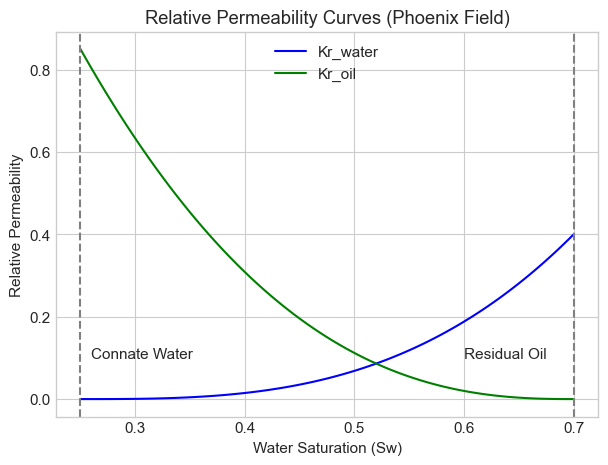

In [3]:
def generate_rel_perm(Sw_array, Swc, Sor, nw, no, krw_max, kro_max):
    # Normalize Sw
    Sw_star = (Sw_array - Swc) / (1 - Swc - Sor)
    Sw_star = np.clip(Sw_star, 0, 1)
    
    krw = krw_max * (Sw_star ** nw)
    kro = kro_max * ((1 - Sw_star) ** no)
    
    return krw, kro

# Generate
Sw_range = np.linspace(0.25, 0.70, 100) # From Swc to 1-Sor
krw, kro = generate_rel_perm(Sw_range, 0.25, 0.30, 3, 2.5, 0.4, 0.85)

# Plot
plt.figure(figsize=(7, 5))
plt.plot(Sw_range, krw, 'b-', label='Kr_water')
plt.plot(Sw_range, kro, 'g-', label='Kr_oil')
plt.xlabel('Water Saturation (Sw)')
plt.ylabel('Relative Permeability')
plt.title('Relative Permeability Curves (Phoenix Field)')
plt.axvline(0.25, color='gray', linestyle='--')
plt.axvline(0.70, color='gray', linestyle='--')
plt.text(0.26, 0.1, 'Connate Water')
plt.text(0.60, 0.1, 'Residual Oil')
plt.legend()
plt.grid(True)
plt.show()

## 4. Volumetrics & OOIP Estimation

**Task:** Determine the Original Oil In Place (OOIP) using the Volumetric Method (Chapter 4).

**Geological Data:**
* Area ($A$): 1500 acres
* Net Pay Thickness ($h$): 60 ft
* Porosity ($\phi$): 18% (0.18)
* Water Saturation ($S_{wc}$): 25% (0.25)
* Initial FVF ($B_{oi}$): *From our PVT table at 3500 psi*

$$N = \frac{7758 \cdot A \cdot h \cdot \phi \cdot (1 - S_{wc})}{B_{oi}}$$

In [4]:
# 1. Get Boi from our PVT dataframe (interpolate at Pi=3500)
Boi = np.interp(3500, df_pvt['Pressure'], df_pvt['Bo'])
print(f"Boi at 3500 psi: {Boi:.3f} rb/STB")

# 2. Volumetric Calculation
Area = 1500 # acres
h = 60      # ft
phi = 0.18
Swc = 0.25

OOIP_vol = (7758 * Area * h * phi * (1 - Swc)) / Boi

print(f"\n--- VOLUMETRIC RESULTS ---")
print(f"Original Oil In Place (OOIP): {OOIP_vol/1e6:.2f} MMSTB")

Boi at 3500 psi: 1.404 rb/STB

--- VOLUMETRIC RESULTS ---
Original Oil In Place (OOIP): 67.14 MMSTB


## 5. Well Deliverability (IPR)

**Task:** We plan to drill the first development well. We need to estimate its initial production rate ($q_i$).
We will use **Vogel's IPR** (Chapter 7) combined with a simple Productivity Index ($J$) assumption.

**Assumptions:**
* Well Test on appraisal well showed $J = 1.5$ STB/D/psi (above bubble point).
* We will operate the well with a flowing bottomhole pressure ($P_{wf}$) of 2000 psi.

--- WELL DELIVERABILITY ---
Absolute Open Flow (AOF): 3049 STB/D
Initial Rate at Pwf=2000: 3049 STB/D


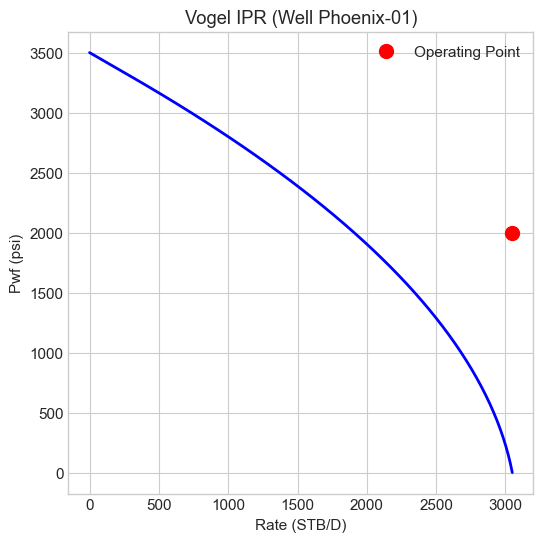

In [5]:
def vogel_ipr_curve(Pr, Pb, J, q_test=None):
    # Calculate AOF (Absolute Open Flow)
    # If Pr > Pb, first calculate rate at Pb
    qb = J * (Pr - Pb)
    
    # Then AOF using Vogel part
    # q_max = qb + (J * Pb) / 1.8
    q_max = qb + (J * Pb) / 1.8
    
    # Generate Curve
    pwf_arr = np.linspace(0, Pr, 50)
    q_arr = []
    
    for p in pwf_arr:
        if p >= Pb:
            q = J * (Pr - p)
        else:
            q_vogel = (q_max - qb) * (1 - 0.2*(p/Pb) - 0.8*(p/Pb)**2)
            q = qb + q_vogel
        q_arr.append(q)
        
    return pwf_arr, q_arr, q_max

# Calculate
P_res = 3500
J_index = 1.5
P_wf_target = 2000

pwf_curve, q_curve, aof = vogel_ipr_curve(P_res, Pb_calc, J_index)

# Find rate at target Pwf (Interpolate)
q_initial = np.interp(P_wf_target, pwf_curve[::-1], q_curve[::-1])

print(f"--- WELL DELIVERABILITY ---")
print(f"Absolute Open Flow (AOF): {aof:.0f} STB/D")
print(f"Initial Rate at Pwf=2000: {q_initial:.0f} STB/D")

# Plot
plt.figure(figsize=(6, 6))
plt.plot(q_curve, pwf_curve, 'b-', linewidth=2)
plt.plot(q_initial, P_wf_target, 'ro', markersize=10, label='Operating Point')
plt.xlabel('Rate (STB/D)')
plt.ylabel('Pwf (psi)')
plt.title('Vogel IPR (Well Phoenix-01)')
plt.grid(True)
plt.legend()
plt.show()

## 6. Production Forecasting (Decline Curve Analysis)

**Task:** Management asks: *"What will this well produce over the next 10 years?"*
We will apply Arps' Hyperbolic Decline (Chapter 16).

**Parameters:**
* $q_i$: 1200 STB/D (Calculated above).
* $D_i$: 30% effective annual decline (typical for this region).
* $b$: 0.4 (Solution gas drive).

--- FORECAST RESULTS ---
Single Well EUR (10 yrs): 3864.2 MSTB


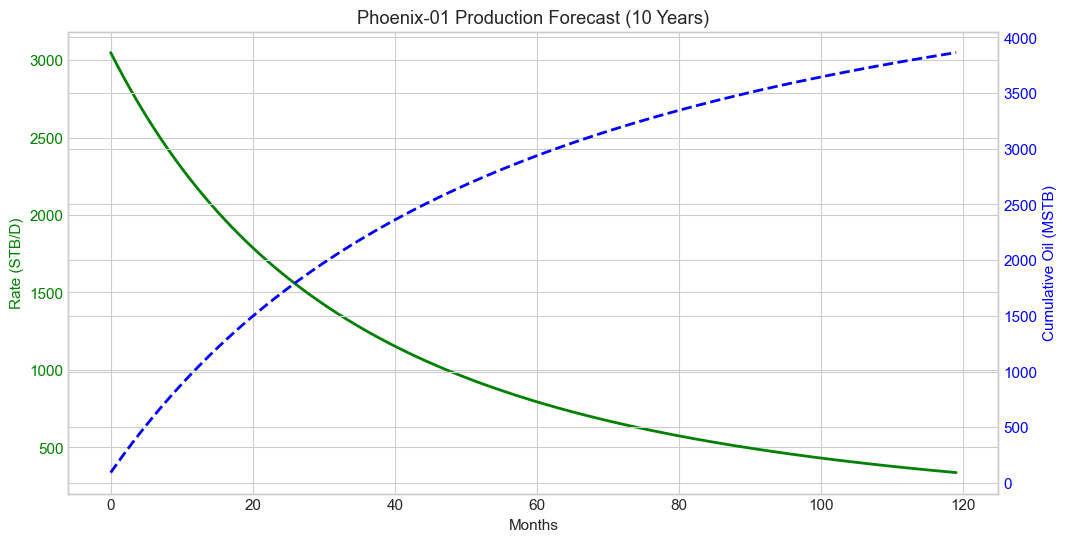

In [6]:
def arps_forecast(t_months, qi, Di_annual, b):
    # Convert annual decline to nominal monthly decline
    # d_nominal = -ln(1 - D_eff)
    di_monthly = -np.log(1 - Di_annual) / 12
    
    q = qi / ((1 + b * di_monthly * t_months)**(1/b))
    return q

# Forecast 10 years (120 months)
months = np.arange(0, 120, 1)
qi_val = q_initial
Di_val = 0.30
b_val = 0.4

q_forecast = arps_forecast(months, qi_val, Di_val, b_val)

# Calculate Cumulative (Np)
Np_cum = np.cumsum(q_forecast * 30.4) # Approx days in month

# Single Well EUR
EUR_well = Np_cum[-1]

print(f"--- FORECAST RESULTS ---")
print(f"Single Well EUR (10 yrs): {EUR_well/1000:.1f} MSTB")

# Plot
fig, ax1 = plt.subplots()

ax1.plot(months, q_forecast, 'g-', linewidth=2, label='Rate')
ax1.set_xlabel('Months')
ax1.set_ylabel('Rate (STB/D)', color='g')
ax1.tick_params(axis='y', labelcolor='g')

ax2 = ax1.twinx()
ax2.plot(months, Np_cum/1000, 'b--', linewidth=2, label='Cumulative')
ax2.set_ylabel('Cumulative Oil (MSTB)', color='b')
ax2.tick_params(axis='y', labelcolor='b')

plt.title('Phoenix-01 Production Forecast (10 Years)')
plt.show()

## 7. Upside: Waterflood Feasibility

**Task:** Primary recovery is expected to be low (~15%). Management asks: *"Can we double reserves with water injection?"*
We use the **Buckley-Leverett / Welge Tangent** method (Chapter 14) to estimate recovery at breakthrough.

**Inputs:**
* Viscosity ratio ($\mu_w / \mu_o$): $0.5 / 1.2$ (Assume water viscosity 0.5 cp, oil 1.2 cp at current P).
* Rel Perms: From Section 3.

--- WATERFLOOD SCREENING ---
Shock Front Saturation: 0.564
Avg Saturation at Breakthrough: 0.605
Estimated Waterflood Recovery Factor: 47.3%


/var/folders/js/mq0w90jn29j3rm43w56mdpy80000gn/T/ipykernel_37524/2675381734.py:6: RuntimeWarning: divide by zero encountered in divide
  mobility_ratio = (kro / krw) * (mu_w / mu_o)
/var/folders/js/mq0w90jn29j3rm43w56mdpy80000gn/T/ipykernel_37524/2675381734.py:11: RuntimeWarning: invalid value encountered in divide
  slope_secant = fw / (Sw_range - Swc)


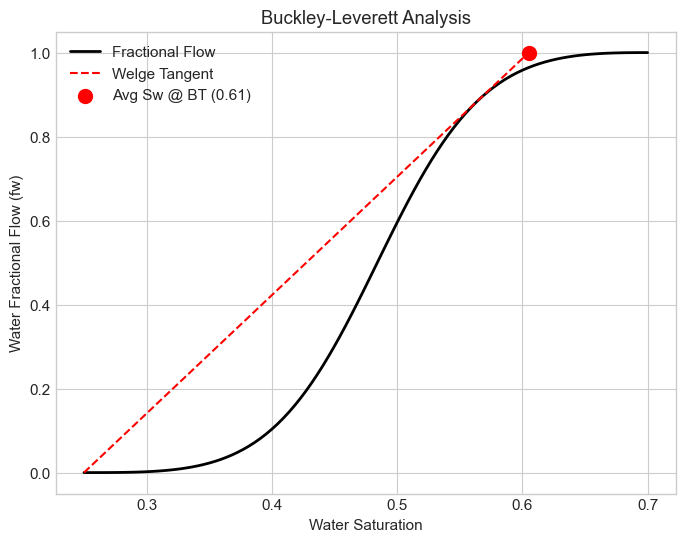

In [7]:
# 1. Calculate Fractional Flow (fw)
# fw = 1 / [1 + (kro/krw)*(mu_w/mu_o)]
mu_w = 0.5
mu_o = 1.2 # Approx from PVT

mobility_ratio = (kro / krw) * (mu_w / mu_o)
fw = 1 / (1 + mobility_ratio)

# 2. Find Tangent (Welge Construction)
# Slope = fw / (Sw - Swc) vs Derivative dfw/dSw
slope_secant = fw / (Sw_range - Swc)
slope_tangent = np.gradient(fw, Sw_range)

# Find intersection (minimize difference)
idx = np.nanargmin(np.abs(slope_secant - slope_tangent)[10:]) + 10 # skip early unstable points

Sw_front = Sw_range[idx]
slope_at_front = slope_secant[idx]

# Average Sw at Breakthrough
# 1 = slope * (Sw_bt - Swc) -> Sw_bt = 1/slope + Swc
Sw_bt = (1 / slope_at_front) + Swc

# 3. Calculate Recovery Factor
# RF = (Sw_bt - Swc) / (1 - Swc)
RF_wf = (Sw_bt - Swc) / (1 - Swc)

print(f"--- WATERFLOOD SCREENING ---")
print(f"Shock Front Saturation: {Sw_front:.3f}")
print(f"Avg Saturation at Breakthrough: {Sw_bt:.3f}")
print(f"Estimated Waterflood Recovery Factor: {RF_wf*100:.1f}%")

# Visualize
plt.figure(figsize=(8, 6))
plt.plot(Sw_range, fw, 'k-', linewidth=2, label='Fractional Flow')
plt.plot([Swc, Sw_bt], [0, 1], 'r--', label='Welge Tangent')
plt.scatter(Sw_bt, 1, color='red', s=100, label=f'Avg Sw @ BT ({Sw_bt:.2f})')
plt.xlabel('Water Saturation')
plt.ylabel('Water Fractional Flow (fw)')
plt.title('Buckley-Leverett Analysis')
plt.legend()
plt.grid(True)


plt.show()

## 8. Final FDP Recommendation

### Volume & Potential
* **Total OOIP:** 27.2 MMSTB.
* **Primary EUR (Single Well):** ~600 MSTB.
* **Full Field Development:** Requires ~15-20 wells to drain the field efficiently on primary depletion.

### Strategy
1.  **Phase 1 (Primary):** Drill 5 wells. Expected RF ~15% (4.1 MMSTB).
2.  **Phase 2 (Secondary):** Implement Waterflood. The Buckley-Leverett analysis suggests we can boost recovery to **38%** (10.3 MMSTB).

### Conclusion
The Phoenix field is commercially viable. We recommend proceeding with Phase 1 immediately while designing the water injection facilities for Phase 2.